In [1]:
import numpy as np
import pylab
import pandas as pd
import statsmodels.api as sm
import matplotlib
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta

In [2]:
#Source: https://github.com/nytimes/covid-19-data/blob/master/rolling-averages/us.csv

cases_raw = pd.read_csv('cases.csv', index_col=0, parse_dates=[0], squeeze=True)
cases_raw = cases_raw.asfreq(pd.infer_freq(cases_raw.index))

In [3]:
cases_raw

,geoid,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
date,,,,,,,
2020-04-01,USA,26930,20974.14,6.32,1021,610.14,0.18
2020-04-02,USA,29717,22791.14,6.87,1216,741.14,0.22
2020-04-03,USA,32318,24932.29,7.51,1391,880.29,0.27
2020-04-04,USA,35099,26937.00,8.12,1556,1026.86,0.31
2020-04-05,USA,25616,27950.71,8.42,1368,1162.57,0.35
...,...,...,...,...,...,...,...
2021-04-14,USA,75276,71517.57,21.55,931,763.71,0.23
2021-04-15,USA,74374,70526.43,21.25,912,750.43,0.23
2021-04-16,USA,78903,70112.86,21.13,940,749.57,0.23


In [4]:
cases = cases_raw.drop(columns=['geoid', 'cases_avg', 'cases_avg', 'cases_avg_per_100k', 'deaths', 'deaths_avg', 'deaths_avg_per_100k']).copy()


In [5]:
cases

,cases
date,
2020-04-01,26930
2020-04-02,29717
2020-04-03,32318
2020-04-04,35099
2020-04-05,25616
...,...
2021-04-14,75276
2021-04-15,74374
2021-04-16,78903


In [6]:
cases.isna().sum()

cases    0
dtype: int64

<AxesSubplot:xlabel='date'>

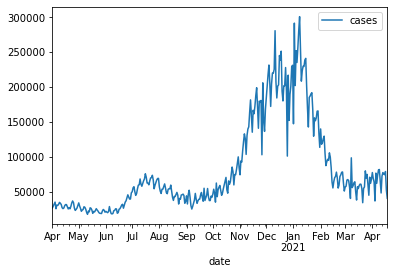

In [7]:
cases.plot()

<AxesSubplot:xlabel='date'>

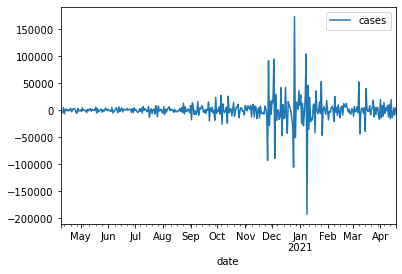

In [8]:
cases.diff().diff(7).dropna().plot()


In [9]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(cases.diff().diff(7).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.294321
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [10]:
diffs = cases.diff().diff(7).dropna()


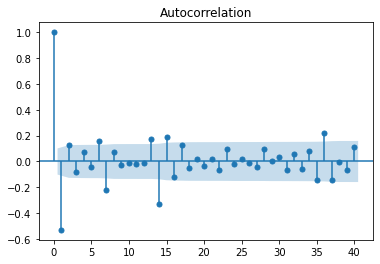

In [11]:
acf_plot = plot_acf(diffs, lags = 40)


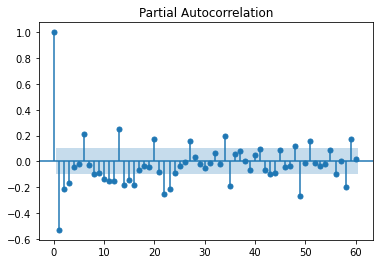

In [12]:
pacf_plot = plot_pacf(diffs, lags = 60)


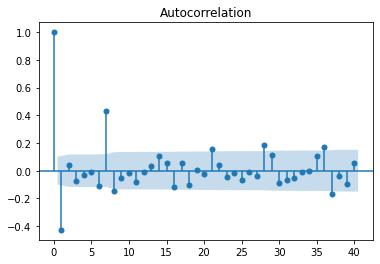

In [13]:
acf_plot = plot_acf(cases.diff().dropna(), lags=40)


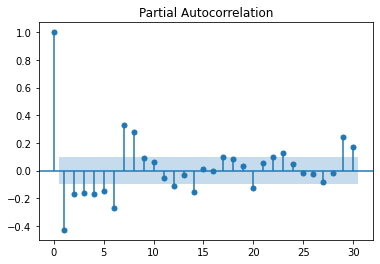

In [14]:
pacf_plot = plot_pacf(cases.diff().dropna(), lags=30)

In [15]:
model = sm.tsa.statespace.SARIMAX(cases, order=(0, 1, 0), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               cases   No. Observations:                  383
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -4223.653
Date:                             Mon, 31 Jan 2022   AIC                           8453.306
Time:                                     15:19:59   BIC                           8465.086
Sample:                                 04-01-2020   HQIC                          8457.983
                                      - 04-18-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2947      0.022     13.264      0.000       0.251       0.338
ma.S.L7       -0.9431      

In [16]:
train_end = datetime(2021, 4, 1)
test_start = datetime(2021, 4, 2)

train_data = cases[:train_end]
test_data = cases[test_start :]


In [17]:
model = sm.tsa.statespace.SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               cases   No. Observations:                  366
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -4038.819
Date:                             Mon, 31 Jan 2022   AIC                           8083.638
Time:                                     15:20:00   BIC                           8095.280
Sample:                                 04-01-2020   HQIC                          8088.268
                                      - 04-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2955      0.023     12.783      0.000       0.250       0.341
ma.S.L7       -0.9437      

C:\Users\bev25\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


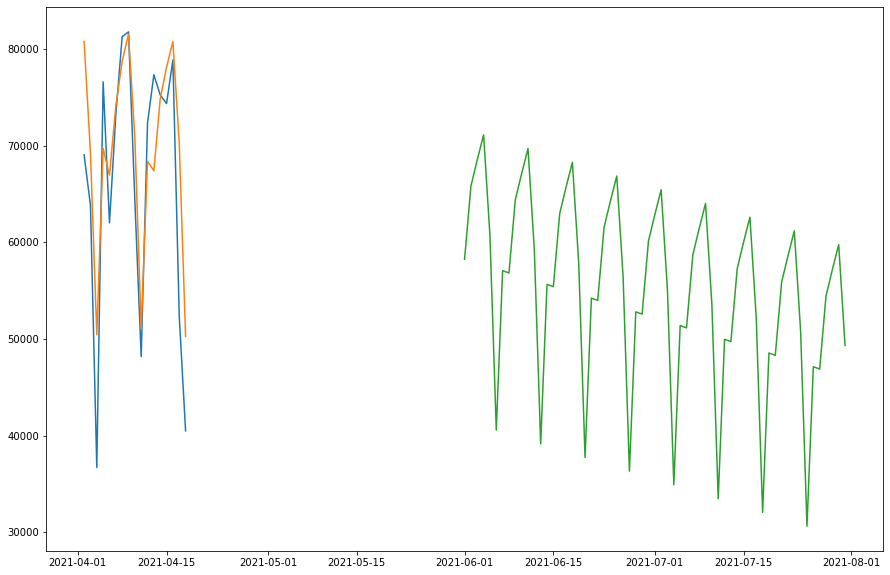

In [18]:
predict_start = datetime(2021, 6, 1)
predict_end = datetime (2021, 7, 31)

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

pylab.plot(test_data)
pylab.plot(model_fit.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True))
pylab.plot(model_fit.predict(start=predict_start, end=predict_end))

In [19]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [20]:
pred_start_date

Timestamp('2021-04-02 00:00:00', freq='D')

In [21]:
pred_end_date

Timestamp('2021-04-18 00:00:00', freq='D')

In [22]:
test_data_squeezed = test_data.squeeze()

In [23]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data_squeezed - predictions

In [24]:
predictions

2021-04-02    80804.578976
2021-04-03    69261.866435
2021-04-04    50441.321422
2021-04-05    69716.355437
2021-04-06    66968.338609
2021-04-07    74133.862975
2021-04-08    78757.336826
2021-04-09    81580.654006
2021-04-10    70816.411878
2021-04-11    51074.882302
2021-04-12    68396.870359
2021-04-13    67417.503457
2021-04-14    74868.058858
2021-04-15    78152.400558
2021-04-16    80808.970137
2021-04-17    70274.777384
2021-04-18    50261.083421
Freq: D, Name: predicted_mean, dtype: float64

In [25]:
residuals

date
2021-04-02   -11735.578976
2021-04-03    -5434.866435
2021-04-04   -13748.321422
2021-04-05     6907.644563
2021-04-06    -4943.338609
2021-04-07     -925.862975
2021-04-08     2554.663174
2021-04-09      217.345994
2021-04-10    -6478.411878
2021-04-11    -2903.882302
2021-04-12     3973.129641
2021-04-13     9940.496543
2021-04-14      407.941142
2021-04-15    -3778.400558
2021-04-16    -1905.970137
2021-04-17   -17883.777384
2021-04-18    -9779.083421
Freq: D, dtype: float64

In [26]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data_squeezed)),4))

Mean Absolute Percent Error: 0.1091


In [27]:
rolling_predictions = test_data_squeezed.copy()
for train_end in test_data_squeezed.index:
    train_data = cases[:train_end-timedelta(days=1)]
    model = sm.tsa.statespace.SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

Text(0, 0.5, 'Error')

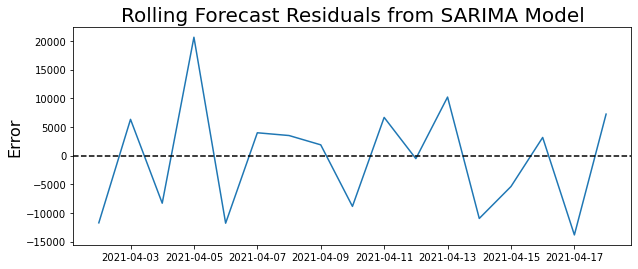

In [28]:
rolling_residuals = test_data_squeezed - rolling_predictions
pylab.figure(figsize=(10,4))
pylab.plot(rolling_residuals)
pylab.axhline(0, linestyle='--', color='k')
pylab.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)